<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit9/TaviTragU9proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 9 Project: Individual Household Electric Power Consumption#

##Setup and importing data##

In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
pip install ucimlrepo

In [16]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
# Take a smaller sample of the data
sample_size = 10000 # Adjust this value as needed
data = individual_household_electric_power_consumption.data.features.sample(n=sample_size, random_state=42) # Added random_state for reproducibility

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Hebrail, Georges and Alice Berard. "Individual Household Electric Power Consumption." UCI Machine Learning Repository, 2006, https://doi.org/10.24432/C58K54.

Surprise surprise I yoinked (wow that's unprofessional sorry) another data set from the UCI machine learning institute. This one is measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available. Note: I have no background in this, I just saw a dataset that had interesting numbers, so I don't know how any of the things are related. I just made some guesses about what to predict/what to predict with.

I took a random sample of 10000 from the dataset because with the whole set (2000000 data points, I kept running out of RAM).



In [17]:
X = data.drop(columns = ['Date', 'Time','Global_active_power']) #here I drop columns I don't want to use as inputs, for my first model, I am going to disregard date and time,
y = data['Global_active_power']                                 #but I think that isn't a great idea, I just don't know how to implement it because they are categorical string
                                                                #data, so I don't know how to order it

# Replace '?' with NaN and drop rows with NaN
X = X.replace('?', np.nan).dropna()
y = y.replace('?', np.nan).dropna()

# Ensure X and y have the same index after dropping NaNs
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

In setting up the data, I drop Date, Time, and the thing I want to predict (global active power). I think date and time are important for predicting the power usage, but because the way the data is formatted (strings and categorical), I don't know how to make them useful. Maybe I will ask gemini later.

In [18]:
# Scale the features using standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32) # Convert y to numpy array and then to float32
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32) # Convert y to numpy array and then to float32

##Model 1: 6 (in)-32-16-8-4-1 (out), RReLU between each hidden layer##

This is the final model that Mr. Arredondo used in the notes, I am going to use it to start.

In [12]:
# Two layer nn with nn.Sequential
model_1 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=6, out_features=32,),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=16, ),
    nn.RReLU(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=16, out_features=8, ),
    nn.RReLU(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.RReLU(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=1, ),
    #outputs a vector of predicted weights
)

In [31]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.0003) #this is how fast it optimizes; smaller is slower, but more consistent

In [32]:
# Set the number of epochs; this is how many times we update our model
epochs = 10000 # Reduced the number of epochs

# Define a batch size for inference
batch_size = 10000  # You can adjust this based on your available RAM

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train.unsqueeze(1)) # Unsqueeze y_train to match the shape of y_pred

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    test_loss = 0
    num_batches = 0
    with torch.inference_mode():
        for i in range(0, len(X_test), batch_size):
            X_batch = X_test[i:i + batch_size]
            y_batch = y_test[i:i + batch_size]

            # 1. Forward pass; makes predictions, but with test data
            test_pred_batch = model_1(X_batch)

            # 2. Calculate the loss for the batch
            test_loss += loss_fn(test_pred_batch, y_batch.unsqueeze(1)) # Unsqueeze y_batch to match the shape of test_pred_batch
            num_batches += 1


    # Print out what's happening
    if epoch % 100 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.01223, Test loss: 0.01125
Epoch: 100 | Train loss: 0.01209, Test loss: 0.01118
Epoch: 200 | Train loss: 0.01226, Test loss: 0.01111
Epoch: 300 | Train loss: 0.01204, Test loss: 0.01104
Epoch: 400 | Train loss: 0.01192, Test loss: 0.01097
Epoch: 500 | Train loss: 0.01208, Test loss: 0.01091
Epoch: 600 | Train loss: 0.01206, Test loss: 0.01084
Epoch: 700 | Train loss: 0.01188, Test loss: 0.01078
Epoch: 800 | Train loss: 0.01194, Test loss: 0.01072
Epoch: 900 | Train loss: 0.01197, Test loss: 0.01066
Epoch: 1000 | Train loss: 0.01175, Test loss: 0.01060
Epoch: 1100 | Train loss: 0.01172, Test loss: 0.01054
Epoch: 1200 | Train loss: 0.01154, Test loss: 0.01048
Epoch: 1300 | Train loss: 0.01171, Test loss: 0.01043
Epoch: 1400 | Train loss: 0.01165, Test loss: 0.01037
Epoch: 1500 | Train loss: 0.01153, Test loss: 0.01032
Epoch: 1600 | Train loss: 0.01133, Test loss: 0.01027
Epoch: 1700 | Train loss: 0.01135, Test loss: 0.01022
Epoch: 1800 | Train loss: 0.01118, Test 

Shoot I should have written thigns down. I believe I ran 2000 epochs with a .0001 LR, 2000 with a .0002 LR, 10000 with a .0005 LR, and 10000 with a .0003 LR.

In [33]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_1(X_test)

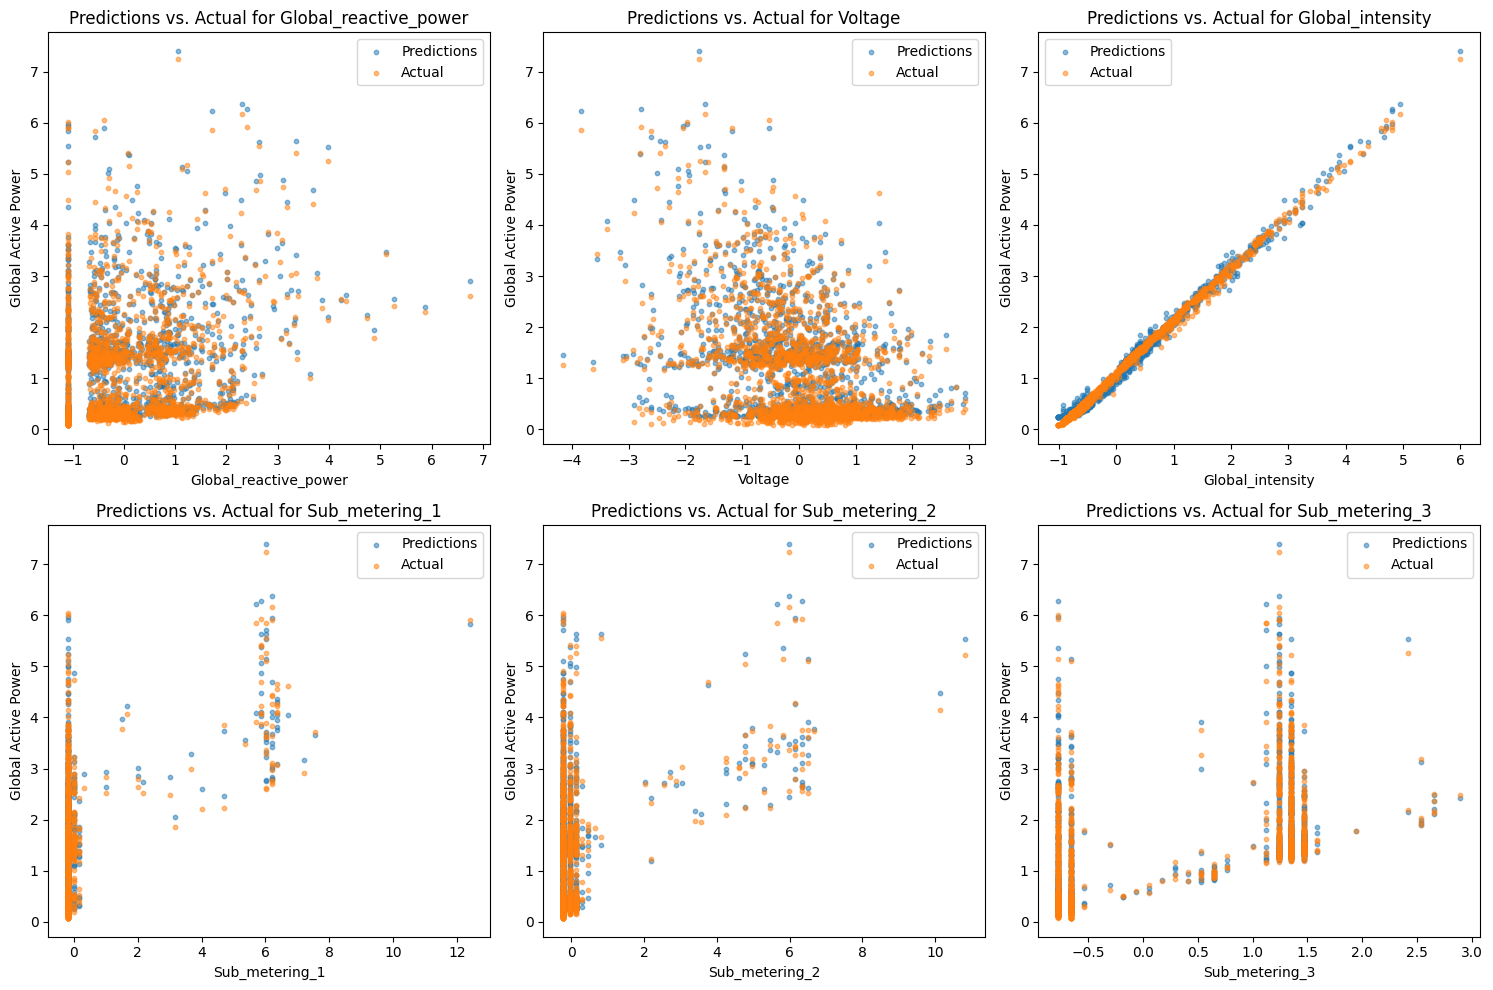

In [36]:
#code from gemini to plot global active power vs all of the inputs

# Ensure y_preds and y_test have the same shape for plotting
y_preds_plot = y_preds.detach().numpy()
y_test_plot = y_test.detach().numpy().reshape(-1, 1) # Reshape y_test to match y_preds

# Get the column names from the original DataFrame X
feature_names = X.columns
num_features = len(feature_names)

# Determine the number of rows and columns for subplots
n_cols = 3 # You can adjust the number of columns as needed
n_rows = (num_features + n_cols - 1) // n_cols # Calculate the number of rows needed

plt.figure(figsize=(15, n_rows * 5)) # Adjust the overall figure size

# Iterate through each feature and create a scatter plot
for i, feature_name in enumerate(feature_names):
    plt.subplot(n_rows, n_cols, i + 1) # Create a subplot

    # Plot predictions
    plt.scatter(X_test[:, i].detach().numpy(), y_preds_plot, label='Predictions', alpha=0.5, s=10) # Reduced marker size

    # Plot actual test data
    plt.scatter(X_test[:, i].detach().numpy(), y_test_plot, label='Actual', alpha=0.5, s=10) # Reduced marker size

    plt.xlabel(feature_name)
    plt.ylabel('Global Active Power')
    plt.title(f'Predictions vs. Actual for {feature_name}')
    plt.legend()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In my plots, the model captured everything. In fact I think it captured too much, I wasn't sure what a good test loss was. I saw that it kept going down after more epochs, so I kept running training. One thing I didn't realise until the 3rd or 4th batch of epochs was that I wasn't starting from scratch each time, but adding on more training to the same model. As a consequence of training it for 24000 epochs instead of 2000 or 10000, it is really overfit now, considering it matches trends to individual data points (although, it would probably be overfit at 10000 also).

##Model 2: 6 (in)-32-4-32-4-1 (out), RReLU between each hidden layer##

Now I am going to use the same data for a second model, this time alternating between large and small layers. I am also going to run this with a slightly higher learning rate (.0005 the whole time) for fewer epochs (2000), and I will make sure to look at the plots more frequently.

In [72]:
# Two layer nn with nn.Sequential
model_2 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=6, out_features=32,),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=4, ),
    nn.RReLU(),

    #moves to hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=32, ),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=4, ),
    nn.RReLU(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=1, ),
    #outputs a vector of predicted weights
)

In [73]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.0005) #this is how fast it optimizes; smaller is slower, but more consistent

In [96]:
# Set the number of epochs; this is how many times we update our model
epochs = 1001

# Define a batch size for inference
batch_size = 10000  # You can adjust this based on your available RAM

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_2.train()

    # 1. Forward pass; makes predictions
    y_pred = model_2(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train.unsqueeze(1)) # Unsqueeze y_train to match the shape of y_pred

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_2.eval() #forces our matrices to stay the same
    test_loss = 0
    num_batches = 0
    with torch.inference_mode():
        for i in range(0, len(X_test), batch_size):
            X_batch = X_test[i:i + batch_size]
            y_batch = y_test[i:i + batch_size]

            # 1. Forward pass; makes predictions, but with test data
            test_pred_batch = model_2(X_batch)

            # 2. Calculate the loss for the batch
            test_loss += loss_fn(test_pred_batch, y_batch.unsqueeze(1)) # Unsqueeze y_batch to match the shape of test_pred_batch
            num_batches += 1


    # Print out what's happening
    if epoch % 100 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.10141, Test loss: 0.06657
Epoch: 100 | Train loss: 0.10011, Test loss: 0.06519
Epoch: 200 | Train loss: 0.09708, Test loss: 0.06385
Epoch: 300 | Train loss: 0.09888, Test loss: 0.06250
Epoch: 400 | Train loss: 0.09784, Test loss: 0.06122
Epoch: 500 | Train loss: 0.09580, Test loss: 0.05999
Epoch: 600 | Train loss: 0.09777, Test loss: 0.05876
Epoch: 700 | Train loss: 0.09305, Test loss: 0.05752
Epoch: 800 | Train loss: 0.09126, Test loss: 0.05634
Epoch: 900 | Train loss: 0.09054, Test loss: 0.05518
Epoch: 1000 | Train loss: 0.08704, Test loss: 0.05402


This image is taken after 2000 epochs with a .0005 LR. I re ran the model with a .001 LR for the same number of epochs to see if it would fit better.
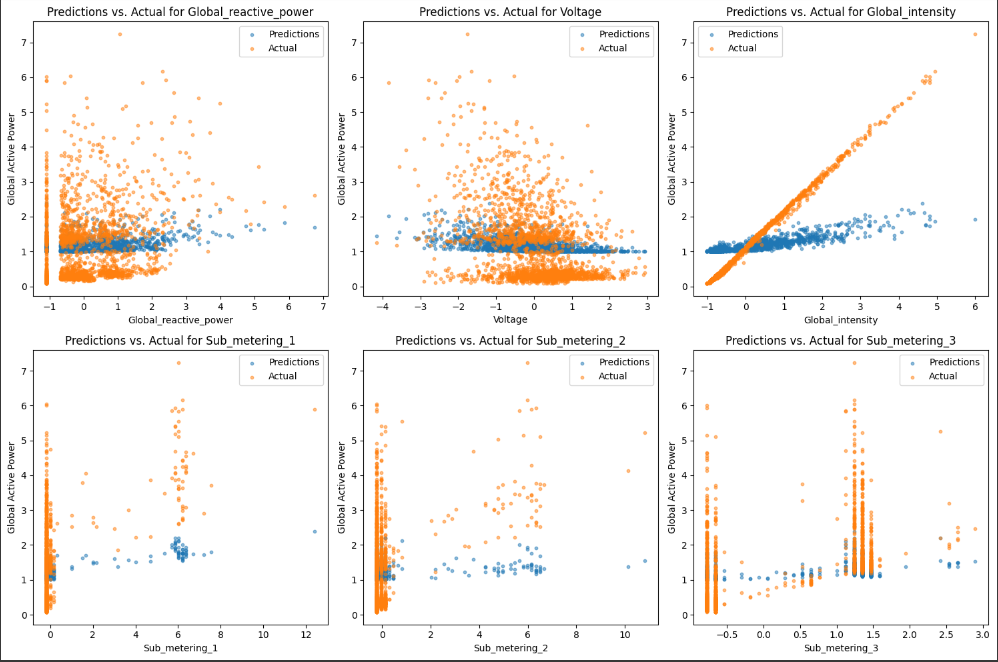

That might have actually performed worse, next I put the learning rate back to .0005 but ran the model for a twice as long.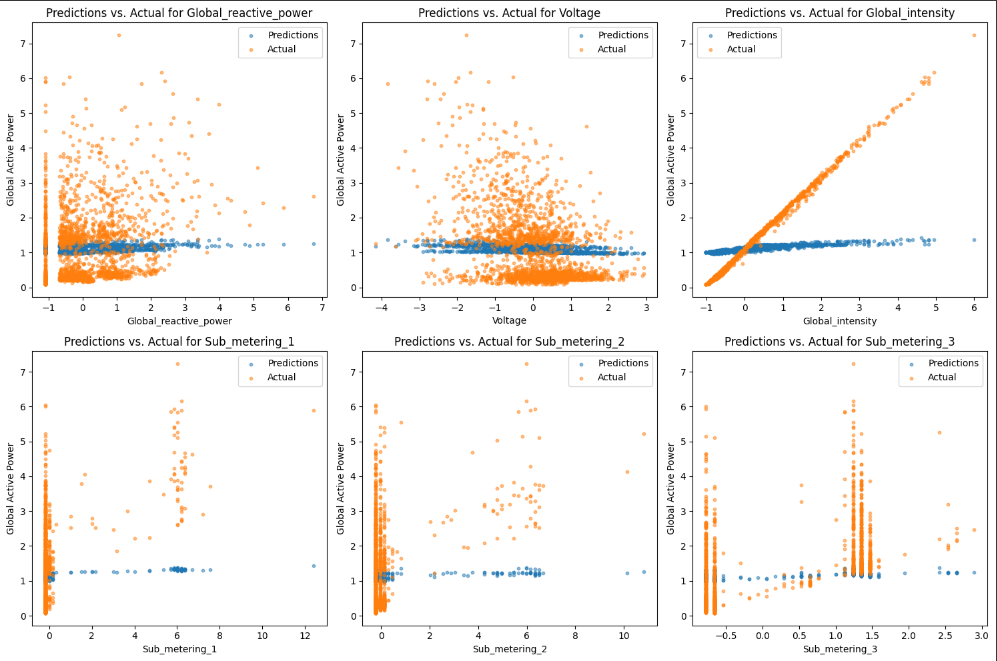

This is working, I am just going to keep running it at a .0005 LR in intervals of 500 epochs until I am satisfied with the fit. 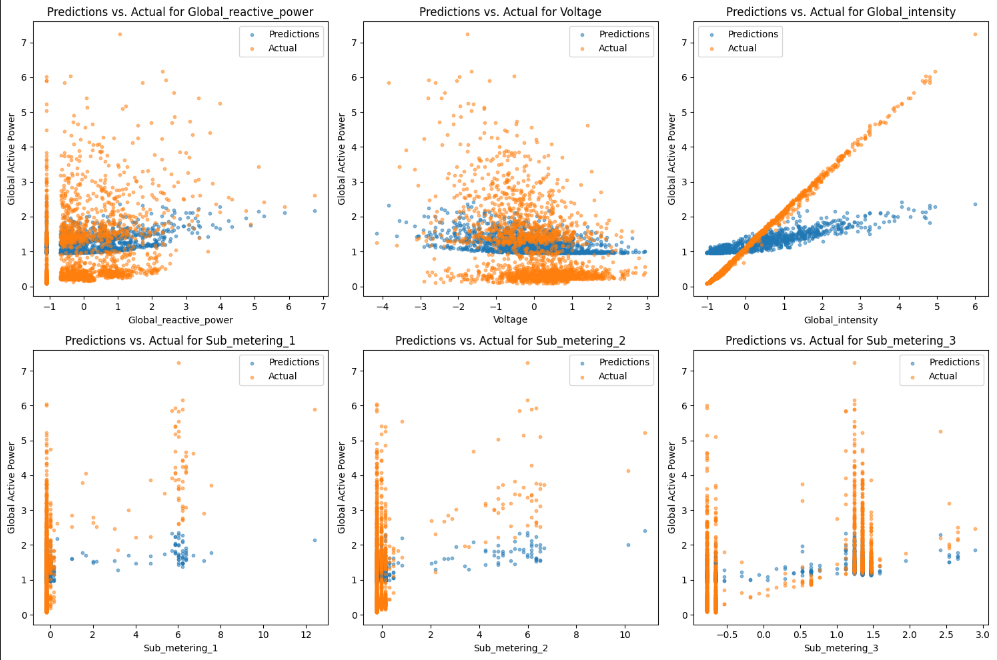

The total number of epochs is 10000

In [94]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test)

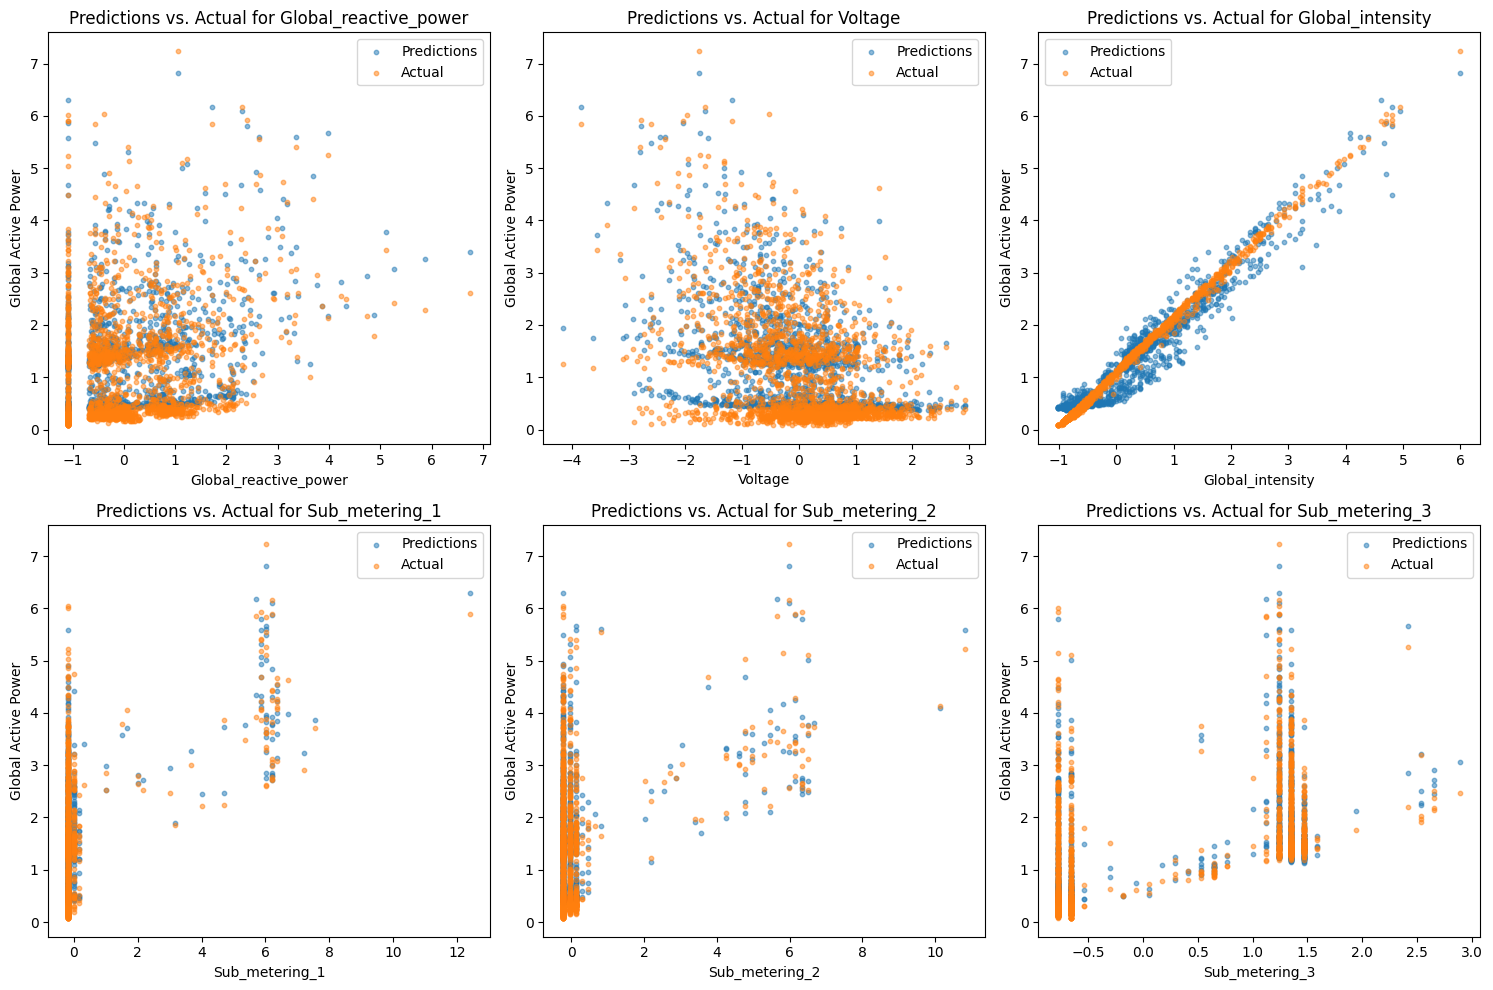

In [97]:
#code from gemini to plot global active power vs all of the inputs

# Ensure y_preds and y_test have the same shape for plotting
y_preds_plot = y_preds.detach().numpy()
y_test_plot = y_test.detach().numpy().reshape(-1, 1) # Reshape y_test to match y_preds

# Get the column names from the original DataFrame X
feature_names = X.columns
num_features = len(feature_names)

# Determine the number of rows and columns for subplots
n_cols = 3 # You can adjust the number of columns as needed
n_rows = (num_features + n_cols - 1) // n_cols # Calculate the number of rows needed

plt.figure(figsize=(15, n_rows * 5)) # Adjust the overall figure size

# Iterate through each feature and create a scatter plot
for i, feature_name in enumerate(feature_names):
    plt.subplot(n_rows, n_cols, i + 1) # Create a subplot

    # Plot predictions
    plt.scatter(X_test[:, i].detach().numpy(), y_preds_plot, label='Predictions', alpha=0.5, s=10) # Reduced marker size

    # Plot actual test data
    plt.scatter(X_test[:, i].detach().numpy(), y_test_plot, label='Actual', alpha=0.5, s=10) # Reduced marker size

    plt.xlabel(feature_name)
    plt.ylabel('Global Active Power')
    plt.title(f'Predictions vs. Actual for {feature_name}')
    plt.legend()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

I think after 10,000 epochs, the fit is pretty good overall. I don't know anything about this household or measuring electricity, so I don't know really how to intrepret the input data. I think I could make a glm that fits better with just Global_intensity, because it seemse like active power = intensity + 1. I could probably get the fit better by running the model longer, but that would come with overfitting. Also this is all from one house, so I think the predictions for the sub metering would not apply to other houses. This could probably be generalized to look at this house in the future. Next I am going to try to get Gemini to convert the date and time data to numbers so it isn't categorical for every individual minute of the day.

##Model 3: Date and Time 2-32-16-8-4-1

In [100]:
#code from gemini to convert time and date to integers.

# Create new dataframes with Date and Time as features and Global_active_power as target
XDT = data[['Date', 'Time']]
yDT = data['Global_active_power']

# Replace '?' with NaN and drop rows with NaN in the new dataframes
XDT = XDT.replace('?', np.nan).dropna()
yDT = yDT.replace('?', np.nan).dropna()

# Ensure XDT and yDT have the same index after dropping NaNs
common_index_dt = XDT.index.intersection(yDT.index)
XDT = XDT.loc[common_index_dt]
yDT = yDT.loc[common_index_dt]

# Convert 'Time' from hh:mm:ss string to minutes since the start of the day
XDT['Time_in_minutes'] = XDT['Time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

# Convert 'Date' to datetime objects and then to day of the year
XDT['Date_datetime'] = pd.to_datetime(XDT['Date'], format='%d/%m/%Y', errors='coerce')
XDT['Day_of_year'] = XDT['Date_datetime'].dt.dayofyear

# Drop the original 'Date' and the intermediate 'Date_datetime' columns, and the original 'Time' column
XDT = XDT.drop(columns=['Date', 'Date_datetime', 'Time'])


display(XDT.head())
display(yDT.head())

,Time_in_minutes,Day_of_year
1870606,1090,188
213926,410,134
409006,1090,269
265806,450,170
1786279,283,130


,Global_active_power
1870606,0.256
213926,0.466
409006,0.758
265806,1.290
1786279,0.428


I asked gemini to turn date and time from strings to integers by making them minutes since start of day and days since start of year. Looking at the code it is just string parcing (which I did a lot of for the small amount of advent of code I actually finished), I probably could have figured it out on my own.

In [101]:
# Scale the features using standardization
scaler = StandardScaler()
XDT_scaled = scaler.fit_transform(XDT)

# Split data into training and testing sets
XDT_train, XDT_test, yDT_train, yDT_test = train_test_split(
    XDT_scaled, yDT, test_size=0.2,
)

# Convert to PyTorch tensors
XDT_train = torch.tensor(XDT_train, dtype=torch.float32)
yDT_train = torch.tensor(yDT_train.values.astype(np.float32), dtype=torch.float32) # Convert y to numpy array and then to float32
XDT_test = torch.tensor(XDT_test, dtype=torch.float32)
yDT_test = torch.tensor(yDT_test.values.astype(np.float32), dtype=torch.float32) # Convert y to numpy array and then to float32

In [102]:
# Two layer nn with nn.Sequential
model_3 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=2, out_features=32,),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=16, ),
    nn.RReLU(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=16, out_features=8, ),
    nn.RReLU(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.RReLU(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=1, ),
    #outputs a vector of predicted weights
)

In [103]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.0005) #this is how fast it optimizes; smaller is slower, but more consistent

In [110]:
# Set the number of epochs; this is how many times we update our model
epochs = 5001

# Define a batch size for inference
batch_size = 10000  # You can adjust this based on your available RAM

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_3.train()

    # 1. Forward pass; makes predictions
    yDT_pred = model_3(XDT_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(yDT_pred, yDT_train.unsqueeze(1)) # Unsqueeze y_train to match the shape of y_pred

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_3.eval() #forces our matrices to stay the same
    test_loss = 0
    num_batches = 0
    with torch.inference_mode():
        for i in range(0, len(XDT_test), batch_size):
            XDT_batch = XDT_test[i:i + batch_size]
            yDT_batch = yDT_test[i:i + batch_size]

            # 1. Forward pass; makes predictions, but with test data
            test_pred_batch = model_3(XDT_batch)

            # 2. Calculate the loss for the batch
            test_loss += loss_fn(test_pred_batch, yDT_batch.unsqueeze(1)) # Unsqueeze y_batch to match the shape of test_pred_batch
            num_batches += 1


    # Print out what's happening
    if epoch % 500 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
    if test_loss <= .055: # Corrected the syntax here
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
        break

Epoch: 0 | Train loss: 1.03852, Test loss: 0.93932
Epoch: 500 | Train loss: 1.03394, Test loss: 0.93272
Epoch: 1000 | Train loss: 1.02905, Test loss: 0.92684
Epoch: 1500 | Train loss: 1.02509, Test loss: 0.92164
Epoch: 2000 | Train loss: 1.02182, Test loss: 0.91709
Epoch: 2500 | Train loss: 1.01885, Test loss: 0.91309
Epoch: 3000 | Train loss: 1.01631, Test loss: 0.90953
Epoch: 3500 | Train loss: 1.01381, Test loss: 0.90632
Epoch: 4000 | Train loss: 1.01184, Test loss: 0.90341
Epoch: 4500 | Train loss: 1.00926, Test loss: 0.90077
Epoch: 5000 | Train loss: 1.00791, Test loss: 0.89833


Here is what the model came up with after 5000 epochs. I am going to run it and see if I can break the for loop when test loss gets below .055 or so (that is about where I ended on model 2, so I assume that will have good fit for model 3). I added:

```
if test_loss <= .055: # Corrected the syntax here
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")
        break
```
to the end of the training for loop to do this. 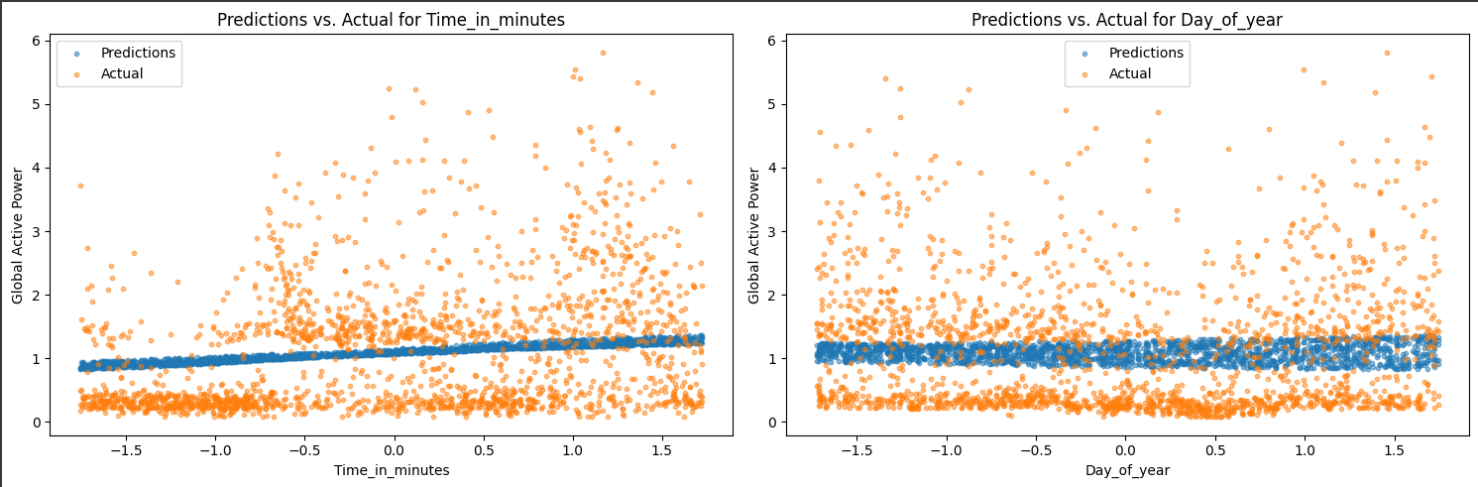


In [106]:
# Turn on evaluation mode
model_3.eval()

# Make predictions (inference)
with torch.inference_mode():
    yDT_preds = model_3(XDT_test)

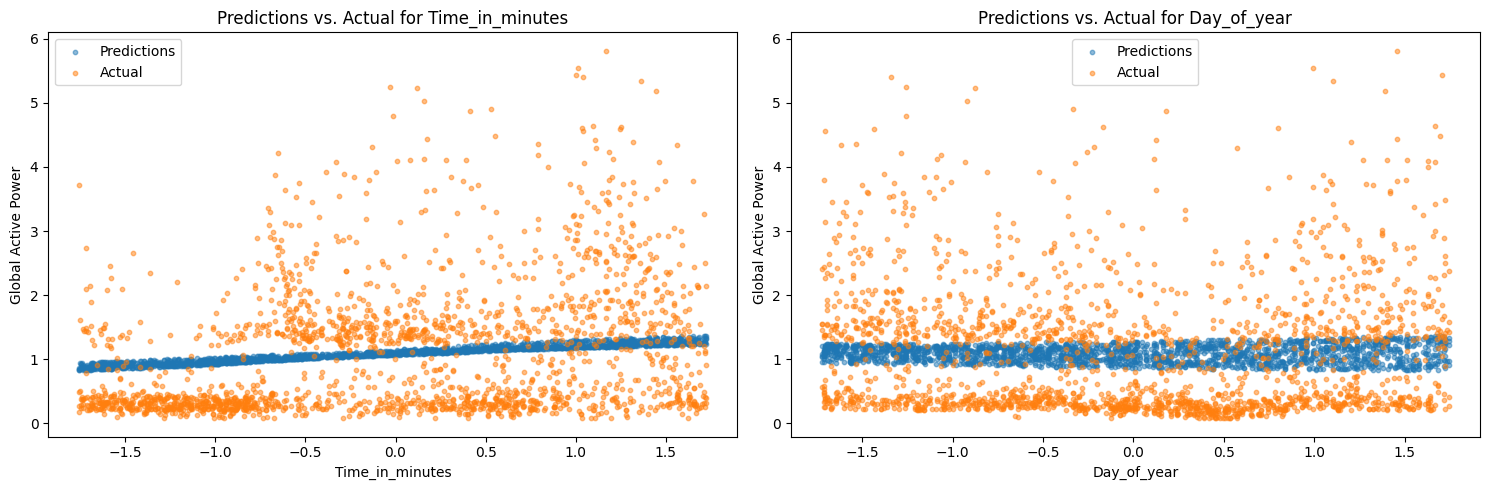

In [111]:
#code from gemini to plot global active power vs all of the inputs

# Ensure y_preds and y_test have the same shape for plotting
yDT_preds_plot = yDT_preds.detach().numpy()
yDT_test_plot = yDT_test.detach().numpy().reshape(-1, 1) # Reshape y_test to match y_preds

# Get the column names from the original DataFrame X
feature_names = XDT.columns
num_features = len(feature_names)

# Determine the number of rows and columns for subplots
n_cols = 2 # You can adjust the number of columns as needed
n_rows = 1

plt.figure(figsize=(15, n_rows * 5)) # Adjust the overall figure size

# Iterate through each feature and create a scatter plot
for i, feature_name in enumerate(feature_names):
    plt.subplot(n_rows, n_cols, i + 1) # Create a subplot

    # Plot predictions
    plt.scatter(XDT_test[:, i].detach().numpy(), yDT_preds_plot, label='Predictions', alpha=0.5, s=10) # Reduced marker size

    # Plot actual test data
    plt.scatter(XDT_test[:, i].detach().numpy(), yDT_test_plot, label='Actual', alpha=0.5, s=10) # Reduced marker size

    plt.xlabel(feature_name)
    plt.ylabel('Global Active Power')
    plt.title(f'Predictions vs. Actual for {feature_name}')
    plt.legend()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

This is after 10000 epochs, I don't think anything changed. The test loss seems really stagnant. I think the data doesn't help, because it is very spread out and almost looks like kaggle data :(. There is a lot of variation over the course of the day and the course of a year. If I could somehow plot this in 3d, I think that would make a trend more apparent (to my eyes, not necessarily to the model). I might start over at a higher learning rate, but I think that because there are 1440 minutes in a day and 365 times each minute happens in a year, there is just too much variation in one x value for the model to catch anything. Also it is scaled weird? Both time and day go from like -1.75 to 1.75 instead of 0-1440 and 0-364.

##Model 4: Date and Time 2-32-4-32-4-1

Didn't get to this yet :(